# Constructing a macronova model using sncosmo

Required ingredients:
* SED for a set of phases, split into 3 numpy arrays:
 * phase: shape N
 * wavelength: shape M
 * flux: shape NxM

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import sncosmo
import warnings
warnings.filterwarnings('ignore')

In [17]:
mn_sed = np.genfromtxt('data/mn_runB_sed.dat')
phase = np.unique(mn_sed[:,0])
wave = mn_sed[mn_sed[:,0] == 0][:,1]
flux = np.array([mn_sed[mn_sed[:,0] == p][:,2] for p in phase])

Use these arrays to define a source which then defines a model

In [28]:
source = sncosmo.TimeSeriesSource(phase, wave, flux)
model = sncosmo.Model(source=source)

print model.param_names
print model.parameters

['z', 't0', 'amplitude']
[ 0.  0.  1.]


Such a model only has three parameter (see above). 

To get magnitudes first set redshift and peak absolute magnitude.

Model parameter "amplitude" now set to: 1.1593275335e-22


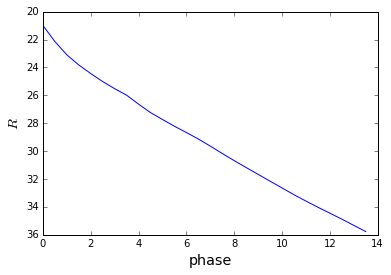

In [31]:
model.set(z=0.01)
model.set_source_peakabsmag(-12.2, 'bessellr', 'vega')

print 'Model parameter "amplitude" now set to:', model.parameters[2] 

mag = model.bandmag('bessellr', 'vega', phase)
plt.plot(phase, mag)
plt.xlabel('phase',fontsize='x-large')
plt.ylabel(r'$R$',fontsize='x-large')
plt.gca().invert_yaxis()

You can also include the effect of Milk Way dust when defining the model.

In [27]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source=source,
                      effects=[dust],
                      effect_names=['mw'],
                      effect_frames=['obs'])

print model.param_names
print model.parameters

['z', 't0', 'amplitude', 'mwebv', 'mwr_v']
[ 0.   0.   1.   0.   3.1]


This added two new parameters: $E(B-V)$ and $R_V$.

Note that astrobject expects these parameters when simulating light-curves.

We can also include the same effect in restframe to add host extinction.

In [37]:
model = sncosmo.Model(source=source,
                      effects=[dust,dust],
                      effect_names=['mw', 'host'],
                      effect_frames=['obs', 'rest'])

print model.param_names
print model.parameters

['z', 't0', 'amplitude', 'mwebv', 'mwr_v', 'hostebv', 'hostr_v']
[ 0.   0.   1.   0.   3.1  0.   3.1]
